In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import environments
import pandas as pd
import simulation_utils
from tqdm import tqdm
from models import ValueIterationNetwork, MCTS, GridWorldNode, softmax

# Example 1: Diffusion (random transitions) with Rewards in corners

In [2]:
# define the enviornment
n_rows, n_columns = 20, 20
grid_shape = (n_rows, n_columns)

sparse_diffusion_matrix = environments.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0
R[n_columns-1] = 1.0 
R[-1] = 1.0
R[-n_columns] = 1.0

gamma = 0.8
iterations = 10

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)


  0%|          | 0/10 [00:00<?, ?it/s]

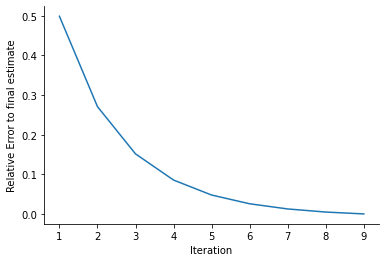

In [3]:
error = np.linalg.norm(V -  np.tile(V[-1,:], (iterations, 1)), axis=1)
plt.plot(np.arange(1, len(error)), error[1:] / np.max(error))
plt.ylabel('Relative Error to final estimate')
plt.xlabel('Iteration')
sns.despine()

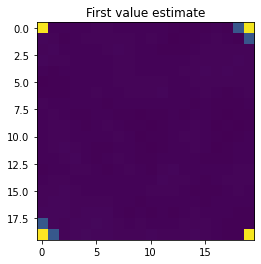

In [4]:
plt.imshow(V[0, :].reshape(grid_shape), cmap='viridis')
plt.title('First value estimate')
# plt.savefig('2dDrift_v0.pdf', dpi=300)

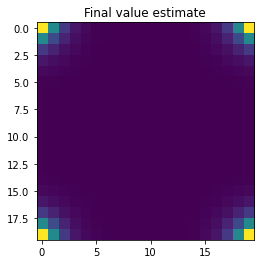

In [5]:
plt.title('Final value estimate')
plt.imshow(V[-1, :].reshape(grid_shape), cmap='viridis', vmin=0, vmax=1)
# plt.savefig('2dDrift_vf.pdf', dpi=300)

# Example 2: 1D Diffusion with Reward on one end

In [6]:
# define the enviornment
n_rows, n_columns = 1, 50

sparse_diffusion_matrix = environments.make_diffision_transition_matrix(n_rows, n_columns, sparse=True)

R = np.ones(n_rows * n_columns) * 0
R[0] = 1.0

iterations = 10000

# helper function
def plot_1d_value_estimates(value_estimates, gamma):
    n_steps = 7
    cc = sns.color_palette('viridis_r', n_colors=n_steps)
    for ii in range(n_steps):
        plt.plot(value_estimates[2**ii, :], label=f'{2**ii}', c=cc[ii])
    plt.plot(value_estimates[-1, :], label=f'10,000', c='k', ls='--')
    plt.ylabel('Estimated Value')
    plt.xlabel('Distance from left edge')
    plt.legend(title='Iteration')
    plt.title(r'$\gamma={}$'.format(gamma))
    sns.despine(trim=True)

def value_estimate_error(value_estimates):
    return np.linalg.norm(value_estimates[:-1:] - np.tile(value_estimates[-1,:], (iterations-1, 1)), axis=1)



  0%|          | 0/10000 [00:00<?, ?it/s]

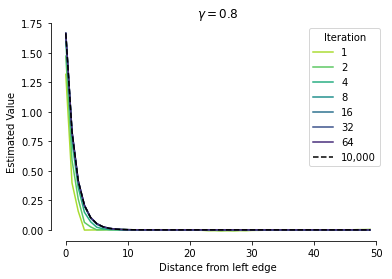

In [7]:
gamma = 0.8

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g08 = value_estimate_error(V)

plot_1d_value_estimates(V, gamma)
# plt.savefig('1dDrift_g8.pdf', dpi=300)

  0%|          | 0/10000 [00:00<?, ?it/s]

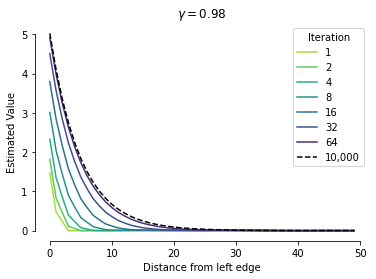

In [8]:
gamma = 0.98

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g098 = value_estimate_error(V)

plot_1d_value_estimates(V, gamma)
# plt.savefig('1dDrift_g98.pdf', dpi=300)

  0%|          | 0/10000 [00:00<?, ?it/s]

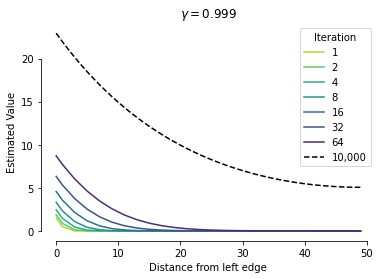

In [9]:
gamma = 0.999

# call the value iteration network
Q, V = ValueIterationNetwork.value_iteration(
    transition_functions = [sparse_diffusion_matrix],
    reward_functions = [R],
    n_rows = n_rows,
    n_columns = n_columns,
    gamma=gamma,
    iterations = iterations,
    return_interim_estimates = True
)

error_g0999 = value_estimate_error(V)


plot_1d_value_estimates(V, gamma)
# plt.savefig('1dDrift_g999.pdf', dpi=300)

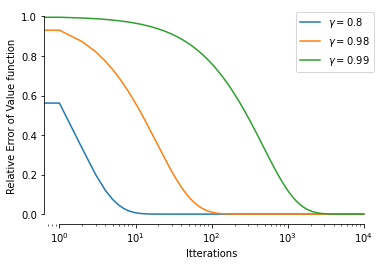

In [10]:
plt.plot(error_g08/np.max(error_g08), label=r'$\gamma = {}$'.format(0.8))
plt.plot(error_g098/np.max(error_g098), label=r'$\gamma = {}$'.format(0.98))
plt.plot(error_g0999/np.max(error_g0999), label=r'$\gamma = {}$'.format(0.99))
plt.xscale('log')
plt.legend()
plt.xlabel('Itterations')
plt.ylabel('Relative Error of Value function')
sns.despine(trim=True)
# plt.savefig('gamma_complexity.pdf', dpi=300)



## Example 3: Needle in a Haystack
This is designed as an example that is difficult for MCTS but easy for Value iteration. Note: these are the first simulations to derive a meaningful policy (the above were diffusion policies).


In [21]:
# define the enviornment
n_rows, n_columns = 4, 4
movement_penalty = -0.10
slip_probability = 0.05

transition_functions, state_reward_function, optimal_policy = environments.make_thread_the_needle(
    n_rows=n_rows,
    n_columns=n_columns,
    movement_penalty=movement_penalty,
    slip_probability=slip_probability,
)


state_action_reward_functions = environments.get_state_action_reward_from_sucessor_rewards(
    state_reward_function, transition_functions
)


grid_shape = (n_rows, n_columns)

goal_state = 0
start_state = n_rows * n_columns - 1

  0%|          | 0/20 [00:00<?, ?it/s]

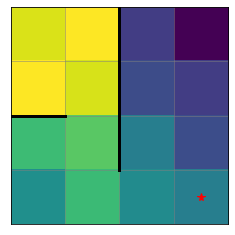

In [75]:
gamma = 0.99

common_model_kwargs = dict(
    transition_functions=transition_functions, 
    reward_functions=state_action_reward_functions,
    n_rows=n_rows, 
    n_columns=n_columns
)



Q, R = ValueIterationNetwork.value_iteration(gamma=gamma, **common_model_kwargs, iterations=20)
plt.imshow(R.reshape(n_rows, n_columns) )
plt.plot(n_rows-1, n_columns-1, '*', c='r', markersize=8)
environments.clean_up_thread_the_needle_plot(plt.gca(), n_columns, n_rows)

Text(-0.1, 0.1, 'G')

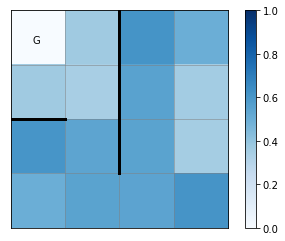

In [77]:
pi = softmax(Q, beta=1)

fig, ax = plt.subplots()

pos  = ax.imshow(1-np.sum(optimal_policy * pi, axis=1).reshape(grid_shape), 
                 cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)


fig.colorbar(pos,  ax=ax)


# sns.despine()
environments.clean_up_thread_the_needle_plot(ax, n_columns, n_rows)
plt.annotate('G', (-.1,.1))
# plt.plot(n_rows-1, n_columns-1, '*', c='r', markersize= 8)



Manhattan Distance from start to goal: 8


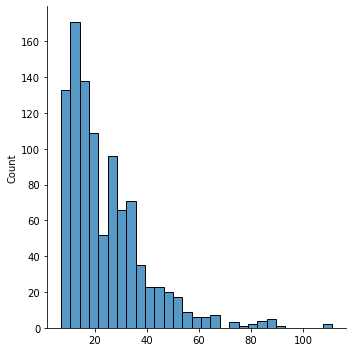

In [78]:
goals_state = 0

sns.displot(
    [len(simulation_utils.sample_trajectory_until_goal(start_state, goals_state, pi, transition_functions)) for _ in range(1000)]
)

# 
# goals_state =
X = np.zeros_like(R)
X[goals_state] = 1
X = X.reshape((n_rows, n_columns))
r_g, c_g = np.argmax(X, axis=0).max(), np.argmax(X, axis=1).max()
d = np.abs(r_g - n_rows) + np.abs(c_g - n_columns)
print(f"Manhattan Distance from start to goal: {d}")

In [109]:
%reload_ext autoreload
from mcts import MCTS, GridWorldNode

node_kwargs = dict(
    end_states=[goals_state],
)

mcts_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=state_reward_function ,
    exploration_weight = 10,
)
mcts = MCTS(**mcts_kwargs)



start_node = GridWorldNode(start_state, **node_kwargs)
for _ in range(5):
    mcts.do_rollout(start_node)

mcts.get_policy()

array([-1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  3, -1, -1,  3,  1])

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0, -1,  1,  3,  1])

AttributeError: 'MCTS' object has no attribute 'get_selection_visit'

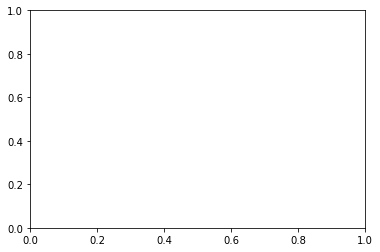

In [71]:

fig, ax = plt.subplots()

pos  = ax.imshow(mcts.get_selection_visit().reshape(grid_shape), vmin=0, )


fig.colorbar(pos,  ax=ax)


# sns.despine()
# environments.clean_up_thread_the_needle_plot(ax, n_columns, n_rows)
plt.annotate('G', (-.1,.1))

In [502]:
mcts.expanded_nodes[15].n

array([0., 0., 0., 1.])

Text(-0.1, 0.1, 'G')

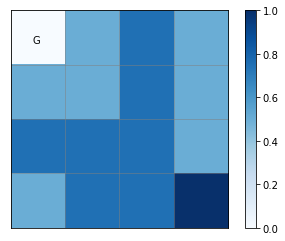

In [460]:
fig, ax = plt.subplots()
score = mcts.score_policy(optimal_policy)

pos  = ax.imshow(score.reshape(grid_shape), 
                 cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
fig.colorbar(pos,  ax=ax)

# sns.despine()
environments.clean_up_thread_the_needle_plot(ax, n_columns, n_rows)
plt.annotate('G', (-.1,.1))

Text(-0.1, 0.1, 'G')

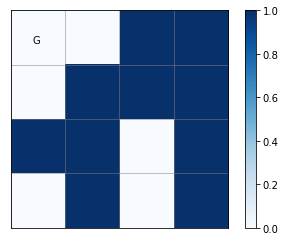

In [462]:
# mcts.do_rollouts(start_node, k=100)

fig, ax = plt.subplots()
score = mcts.score_policy(optimal_policy)

pos  = ax.imshow(score.reshape(grid_shape), 
                 cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=1)
fig.colorbar(pos,  ax=ax)

# sns.despine()
environments.clean_up_thread_the_needle_plot(ax, n_columns, n_rows)
plt.annotate('G', (-.1,.1))


In [181]:
# simulate search depths for thread the needle
simulations = []

iterations = 100

for s in tqdm(range(4, 21, 2)):

    n_rows, n_columns = s, s
    movement_penalty = -0.10
    slip_probability = 0.05

    transition_functions, state_action_reward_functions = environments.make_thread_the_needle(
        n_rows=n_rows,
        n_columns=n_columns,
        movement_penalty=movement_penalty,
        slip_probability=slip_probability
    )
    start_state = n_rows * n_columns - 1
    
    node_kwargs = dict(
    end_states=[goals_state],
    transition_functions=transition_functions,
    state_reward_function=state_reward_function
    )
    start_node = GridWorldNode(start_state, **node_kwargs)


    
    
    for ii in range(iterations):
#         depth = int(np.round((start_node.simulate(a) - 1) / movement_penalty))
        depth = start_node.get_simulation_depth()
        simulations.append({
            'Number of states': s**2,
            'Search Depth': depth,
            'Iteration': ii
        })
        
simulations = pd.DataFrame(simulations)

100%|██████████| 9/9 [06:00<00:00, 40.09s/it]


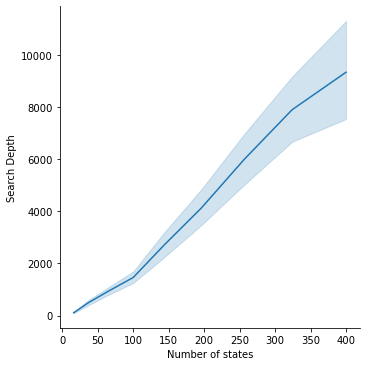

In [185]:
sns.relplot(x='Number of states', y='Search Depth', data=simulations, kind='line')


In [116]:
from tqdm import tnrange
for ii in tnrange(10):
    mcts.do_rollout(start_node)


<ipython-input-116-d8c4c022482f>:2: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for ii in tnrange(10):


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
# 0 = up, 1 = left, 2 = right, 3 = down
mcts.get_policy().reshape((n_rows, n_columns))

array([[-1,  0,  1,  3],
       [ 0,  1,  2,  0],
       [ 1,  1,  2,  2],
       [ 3,  1,  3,  2]])